# Initialization

In [140]:
!pip install -U sentence-transformers

Requirement already up-to-date: sentence-transformers in /usr/local/lib/python3.7/dist-packages (1.1.0)


In [141]:
from sentence_transformers import SentenceTransformer, util
import torch
import json
import numpy as np
import pandas as pd

In [169]:
ISSUES_FILE = 'drive/MyDrive/bugs_data/eall.csv'
CUSTOM_MODEL_PATH = 'drive/MyDrive/bugs_data/models/stsb-distilbert-base-ooall-40000'

# Issues Helper Methods

In [170]:
def get_issues(issues_file):
  issues = pd.read_csv(issues_file)
  issues['full_description'] = issues['short_desc'].astype(str) + '\n' + issues['description'].astype(str)
  return issues

# Model Helper Methods

In [171]:
def get_base_model():
  return SentenceTransformer('paraphrase-distilroberta-base-v1')

In [172]:
def get_custom_model(name):
  return SentenceTransformer(name)

# Main

In [173]:
issues = get_issues(ISSUES_FILE)

In [174]:
issues = issues.iloc[-10000:].reset_index(drop=True)

In [175]:
len(issues)

10000

In [176]:
model = get_custom_model('drive/MyDrive/bugs_data/models/paraphrase-distilroberta-base-v1-eall-40000')

In [187]:
model = get_base_model()

Gather the newest duplicates from the issues set

In [188]:
issues_new_duplicates = issues.iloc[-1500:].loc[issues['dup_id'] == issues['dup_id']].reset_index(drop=True)

Ensure that the newest duplicates gathered are not in the set of issues from which we will try to retrieve top-k similar issues

In [189]:
issues_pool = issues[~issues['bug_id'].isin(issues_new_duplicates['bug_id'])].reset_index(drop=True)

Calculate embeddings for the issues pool

In [190]:
embeddings = model.encode(np.array(issues_pool['full_description']), convert_to_tensor=True)

# Top-K Retrieval Methods

In [191]:
def get_top_k_similar_issues(query_embedding, embeddings, top_k):
  return util.semantic_search(query_embedding, embeddings, top_k=top_k)[0]

In [192]:
def evaluate_recall_at_top_k(model, query_issues, pool_issues, embeddings, top_k):
  count = 0
  correct = 0
  for index, row in query_issues.iterrows():
    count += 1
    query_embedding = model.encode(row['full_description'], convert_to_tensor=True)
    results = get_top_k_similar_issues(query_embedding, embeddings, top_k)
    correct_prediction_found = False
    for result in results:
      result_issue = pool_issues.iloc[result['corpus_id']]
      if result_issue['master_id'] == row['master_id']:
        correct_prediction_found = True
    if correct_prediction_found:
      correct += 1
    print(correct / count)
  return correct / count
    


In [199]:
evaluate_recall_at_top_k(model, issues_new_duplicates, issues_pool, embeddings, 25)

1.0
1.0
1.0
1.0
0.8
0.6666666666666666
0.5714285714285714
0.625
0.6666666666666666
0.6
0.5454545454545454
0.5833333333333334
0.6153846153846154
0.6428571428571429
0.6666666666666666
0.6875
0.7058823529411765
0.6666666666666666
0.631578947368421
0.65
0.6190476190476191
0.5909090909090909
0.5652173913043478
0.5416666666666666
0.56
0.5384615384615384
0.5555555555555556
0.5357142857142857
0.5172413793103449
0.5
0.5161290322580645
0.53125
0.5454545454545454
0.5588235294117647
0.5428571428571428
0.5555555555555556
0.5675675675675675
0.5789473684210527
0.5897435897435898
0.6
0.5853658536585366
0.5952380952380952
0.5813953488372093
0.5681818181818182
0.5777777777777777
0.5652173913043478
0.5531914893617021
0.5625
0.5714285714285714
0.56
0.5686274509803921
0.5576923076923077
0.5471698113207547
0.5370370370370371
0.5272727272727272
0.5357142857142857
0.543859649122807
0.5517241379310345
0.559322033898305
0.55
0.5573770491803278
0.5483870967741935
0.5555555555555556
0.546875
0.5538461538461539
0.

0.5352112676056338

# Fine-Tuning with OnlineContrastiveLoss

In [1]:
!pip install -U sentence-transformers

     |████████████████████████████████| 81kB 8.0MB/s 
     |████████████████████████████████| 2.1MB 27.3MB/s 
     |████████████████████████████████| 1.2MB 50.9MB/s 
     |████████████████████████████████| 901kB 53.8MB/s 
     |████████████████████████████████| 3.3MB 36.7MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-1.1.0-cp37-none-any.whl size=119615 sha256=2ede0615358e13745ae21cdeb5ab4695f39ede4a8ca54686502aa710443f806c
  Stored in directory: /root/.cache/pip/wheels/84/cb/21/1066bff3027215c760ca14a198f698bca8fccb92e33e2327eb
Successfully built sentence-transformers


In [2]:
!pip install torchviz

  Created wheel for torchviz: filename=torchviz-0.0.2-cp37-none-any.whl size=4152 sha256=82c945426bcbb2bf658fca81d625bb494110cb698e9cd719bd7fc0242c7de9a4
  Stored in directory: /root/.cache/pip/wheels/01/26/58/026ffd533dbe8b3972eb423da9c7949beca68d1c98ed9e8624
Successfully built torchviz


In [6]:
from sentence_transformers import SentenceTransformer, InputExample, losses, evaluation
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import torch

In [24]:
PAIRS_FILE = 'drive/MyDrive/bugs_data/eall_pairs_40000.csv'
MODEL_OUTPUT_PATH = 'drive/MyDrive/bugs_data/models/paraphrase-distilroberta-base-v1-eall-40000'

In [25]:
pairs = pd.read_csv(PAIRS_FILE)
pairs_train, pairs_test = train_test_split(pairs, test_size=0.1)

In [26]:
train_data = []
for index, pair in pairs_train.iterrows():
  train_sample = InputExample(texts=[pair['description_1'], pair['description_2']], label=float(pair['label']))
  train_data.append(train_sample)

In [27]:
descriptions_1 = pairs_test['description_1'].to_list()
descriptions_2 = pairs_test['description_2'].to_list()
scores = pairs_test['label'].to_list()

In [28]:
model = SentenceTransformer('paraphrase-distilroberta-base-v1')

In [29]:
distance_metric = losses.SiameseDistanceMetric.COSINE_DISTANCE
margin = 0.5

In [30]:
evaluator = evaluation.EmbeddingSimilarityEvaluator(descriptions_1, descriptions_2, scores, write_csv=True)

In [31]:
train_dataloader = DataLoader(train_data, shuffle=True, batch_size=64)
train_loss = losses.OnlineContrastiveLoss(model=model, distance_metric=distance_metric, margin=margin)

In [ ]:
model.fit(train_objectives=[(train_dataloader, train_loss)], epochs=5, warmup_steps=100, evaluator=evaluator, evaluation_steps=50, output_path=MODEL_OUTPUT_PATH, save_best_model=True)

In [ ]:
model.save(MODEL_OUTPUT_PATH)

Evaluate Embeddings

In [73]:
import matplotlib.pyplot as plt

In [138]:
model_to_evaluate = SentenceTransformer('paraphrase-distilroberta-base-v1')

In [135]:
def evaluate_embeddings(model, pairs):
  evaluations_list = []
  for index, row in pairs.iterrows():
    embedding_1 = model.encode(row['description_1'], convert_to_tensor=True)
    embedding_2 = model.encode(row['description_2'], convert_to_tensor=True)
    cos_similarity = torch.nn.CosineSimilarity(dim=0, eps=1e-6)
    similarity = cos_similarity(embedding_1, embedding_2)
    evaluations_list.append({
        'prediction': similarity.item(),
        'label': row['label']
    })
  df = pd.DataFrame(evaluations_list)
  df['prediction'] = (df['prediction'] - df['prediction'].min()) / (df['prediction'].max() - df['prediction'].min())  
  colors = {0: '#ff6361', 1: '#58508d'}
  plt.scatter(df.index, df['prediction'], c=df['label'].map(colors), s=5)
  plt.xticks([])
  plt.savefig('temp.png', dpi=300)
  plt.show()

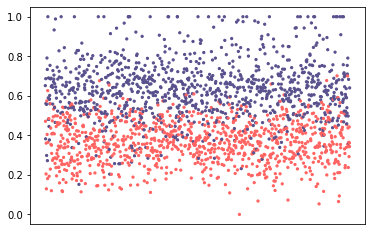

In [139]:
evaluate_embeddings(model_to_evaluate, pairs_test[-2000:])